#Starter Notebook
##Install and import required libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import (
    RobertaForSequenceClassification,
    RobertaTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType
)
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle

##Load Tokenizer and Preprocess Data

In [3]:
# Constants
BASE_MODEL = "roberta-base"
DATASET_NAME = "ag_news"
OUTPUT_DIR = "roberta_lora_agnews_results"
MAX_LENGTH = 128
RANDOM_SEED = 37

# Load Dataset
dataset = load_dataset(DATASET_NAME, split='train')
print(f"Loaded {len(dataset)} training samples.")

# Load Tokenizer
print(f"Loading tokenizer for base model: {BASE_MODEL}")
tokenizer = RobertaTokenizer.from_pretrained(BASE_MODEL)

# Preprocessing Function
def preprocess(examples):
    """Tokenizes the text data with consistent parameters."""
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors=None # for batch processing
    )

# Apply Preprocessing
tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    remove_columns=["text"]
    )
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Explicit label mapping ensures consistency between training and inference
id2label = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}
label2id = {v: k for k, v in id2label.items()}

print("Explicit label mapping for model:")
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Loaded 120000 training samples.
Loading tokenizer for base model: roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Explicit label mapping for model:
id2label: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
label2id: {'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}


In [4]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


##Load Pre-trained Model
##Set up config for pretrained model and download it from hugging face

In [5]:
model = RobertaForSequenceClassification.from_pretrained(
    BASE_MODEL,
    num_labels=4,
    id2label=id2label,
    label2id=label2id)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

##Anything from here on can be modified

In [6]:
# Split Dataset
split_datasets = tokenized_dataset.train_test_split(
    test_size=0.1,
    seed=37,
    stratify_by_column="labels"
    )
train_dataset = split_datasets["train"]
eval_dataset = split_datasets["test"]
print(f"Training set size: {len(train_dataset)}")
print(f"Evaluation set size: {len(eval_dataset)}")

Training set size: 108000
Evaluation set size: 12000


In [7]:
# Freeze all parameters of the base model
for param in model.parameters():
    param.requires_grad = False

##Setup LoRA Config
##Setup PEFT config and get peft model for finetuning

In [8]:
# Running PEFT Config on LoRA configuration
peft_config = LoraConfig(
    r=8, # Rank of the update matrices, higher it is, better the capacity
    lora_alpha=16, # LoRA scaling factor = 2*Rank
    lora_dropout=0.2, # Dropout probability for LoRA layers
    bias = 'lora_only',
    target_modules = ["query", "value"],
    task_type="SEQ_CLS",
)

In [9]:
print("Applying LoRA configuration to the base model-")
peft_model = get_peft_model(model, peft_config)
peft_model

Applying LoRA configuration to the base model-


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.2, inplace=False)
                    )
                    (lora_A): Mod

In [10]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 907,012 || all params: 125,537,288 || trainable%: 0.7225


In [11]:
# Calculate trainable parameters manually for verification
trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in peft_model.parameters())
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.4f}%")

# Verify we're under 1M trainable parameters
assert trainable_params < 1_000_000, "Trainable parameters exceed 1 million!"

Trainable parameters: 907,012
Total parameters: 125,537,288
Percentage of trainable parameters: 0.7225%


In [12]:
print("Trainable parameters:")
for name, param in peft_model.named_parameters():
    if param.requires_grad:
         print(name)

Trainable parameters:
base_model.model.roberta.encoder.layer.0.attention.self.query.base_layer.bias
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.base_layer.bias
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.base_layer.bias
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.base_layer.bias
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_B.default.w

##Training Setup

In [13]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# To track evaluation accuracy during training
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [14]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir="roberta-lora-agnews-results",
    # learning_rate=5e-4,
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=6,
    # max_steps=1200 # consider either max steps or desired epochs
    eval_strategy='steps', # Evaluate during training
    eval_steps=200,
    save_strategy="steps", # Save checkpoints during training
    save_steps=200, # Save checkpoints at the same frequency as evaluation
    load_best_model_at_end=True, # Load the best model found during training
    metric_for_best_model="accuracy", # Use accuracy to determine the best model
    greater_is_better=True,
    weight_decay=0.01,
    optim="adamw_torch",
    max_grad_norm=1.0,
    lr_scheduler_type="linear",
    report_to=None, # Disable default reporting integrations like wandb/tensorboard unless configured
    fp16=torch.cuda.is_available(), # Use mixed precision if GPU is available
    gradient_accumulation_steps=4, # Accumulate gradients to simulate larger batch size if needed
    warmup_ratio=0.1, # Add a learning rate warmup phase
    seed=37,
    logging_steps=50,
    gradient_checkpointing=True, # Enable if memory is constrained, might slow down training
)

print("\nTraining Arguments:")
print(training_args)


Training Arguments:
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=200,
eval_strategy=IntervalStrategy.STEPS,
eval_use

In [15]:
# initialize trainer
def get_trainer(model):
      return  Trainer(
          model=peft_model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
          tokenizer=tokenizer,
      )

##Start Training

In [17]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

<ipython-input-15-ebcae904fc20>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return  Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nm4709 (nm4709-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
200,1.338000,1.321660,0.814250
400,1.124400,1.078553,0.851083
600,0.755700,0.667581,0.869000
800,0.565600,0.479017,0.878417
1000,0.490800,0.400554,0.886583
1200,0.446700,0.367915,0.886167
1400,0.446900,0.345675,0.891917
1600,0.425700,0.335295,0.893250
1800,0.430500,0.324452,0.896583
2000,0.413900,0.318958,0.897750


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn

In [18]:

# Save Final Model
print("Training finished. Saving model...")
peft_lora_finetuning_trainer.save_model(os.path.join(OUTPUT_DIR, "final_model"))
tokenizer.save_pretrained(os.path.join(OUTPUT_DIR, "final_model"))

Training finished. Saving model...


('roberta_lora_agnews_results/final_model/tokenizer_config.json',
 'roberta_lora_agnews_results/final_model/special_tokens_map.json',
 'roberta_lora_agnews_results/final_model/vocab.json',
 'roberta_lora_agnews_results/final_model/merges.txt',
 'roberta_lora_agnews_results/final_model/added_tokens.json')

In [19]:
# Evaluate Model
eval_metrics = peft_lora_finetuning_trainer.evaluate()
print(f"Final evaluation metrics: {eval_metrics}")

Final evaluation metrics: {'eval_loss': 0.29605984687805176, 'eval_accuracy': 0.9005, 'eval_runtime': 6.915, 'eval_samples_per_second': 1735.36, 'eval_steps_per_second': 27.187, 'epoch': 5.993185185185185}


In [20]:
def classify(model, tokenizer, text):
    """Run inference on a single text example."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(**inputs)
    prediction = output.logits.argmax(dim=-1).item()
    print(f'Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

##Run Inference on eval_dataset

In [21]:
# Run Inference on Test Examples
test_examples = [
    "Wall Street rallies as tech stocks surge to new heights",
    "Manchester United wins dramatic match against Liverpool",
    "New study reveals breakthrough in cancer treatment",
    "Tech company announces innovative AI product",
    "NVIDIA owns AI"
]

print("\nRunning inference on test examples:")
for text in test_examples:
    result = classify(peft_model, tokenizer, text)


Running inference on test examples:
Class: 2, Label: Business, Text: Wall Street rallies as tech stocks surge to new heights
Class: 1, Label: Sports, Text: Manchester United wins dramatic match against Liverpool
Class: 3, Label: Sci/Tech, Text: New study reveals breakthrough in cancer treatment
Class: 3, Label: Sci/Tech, Text: Tech company announces innovative AI product
Class: 3, Label: Sci/Tech, Text: NVIDIA owns AI


In [22]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=32, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
      # Loop over the DataLoader
      for batch in tqdm(eval_dataloader, desc="Evaluating"):
          # Move each tensor in the batch to the device
          batch = {k: v.to(device) for k, v in batch.items()}

          # Forward pass
          outputs = inference_model(**batch)
          predictions = outputs.logits.argmax(dim=-1)

          all_predictions.extend(predictions.cpu().numpy())
          if labelled and "labels" in batch:
              all_labels.extend(batch["labels"].cpu().numpy())
              # Calculate accuracy
              metric = evaluate.load('accuracy')

    # Compute metrics if dataset is labelled
    if labelled and all_labels:
        accuracy = accuracy_score(all_labels, all_predictions)

        metrics = {
            "accuracy": accuracy,
        }

        print(f"Evaluation metrics: {metrics}")
        return metrics, all_predictions

    return all_predictions

In [23]:
# Process Test Data for Submission
try:
    print("\nLoading test data for Kaggle submission...")
    test_data_path = "test_unlabelled.pkl"

    # Load the pickle file
    test_df = pd.read_pickle(test_data_path)
    print(f"Loaded data type: {type(test_df)}")

    # If it's already a Dataset object, convert to DataFrame first
    if hasattr(test_df, 'to_pandas'):
        print("Converting Dataset to DataFrame...")
        test_df = test_df.to_pandas()
    elif not isinstance(test_df, pd.DataFrame):
        print(f"Unexpected data type: {type(test_df)}. Converting to DataFrame...")
        if hasattr(test_df, 'features'):
            # It's a Dataset-like object
            test_df = pd.DataFrame({col: test_df[col] for col in test_df.column_names})
        else:
            # Try to convert directly
            test_df = pd.DataFrame(test_df)

    print(f"Successfully loaded test data with shape: {test_df.shape}")

    # Ensure 'ID' column exists in the DataFrame
    if "ID" not in test_df.columns:
        test_df["ID"] = range(len(test_df))

    # Convert to Hugging Face Dataset
    test_dataset = Dataset.from_pandas(test_df)

    # Apply the same preprocessing as training data
    test_dataset = test_dataset.map(preprocess, batched=True, remove_columns=["text"])

    # Run inference
    print("Running inference on test data...")
    predictions = peft_lora_finetuning_trainer.predict(test_dataset)
    pred_labels = np.argmax(predictions.predictions, axis=-1)

    # Create submission DataFrame with EXACT column names required
    submission_df = pd.DataFrame({
        'ID': test_df["ID"],  # Use the original IDs from the test set!
        'Label': pred_labels  # Numeric labels (0, 1, 2, 3)
    })

    # Save to CSV without index
    submission_path = os.path.join(OUTPUT_DIR, "kaggle_submission.csv")
    submission_df.to_csv(submission_path, index=False)
    print(f"Kaggle submission file saved to {submission_path}")
    print(submission_df.head())

except Exception as e:
    print(f"Error processing test data: {e}")
    import traceback
    traceback.print_exc()


Loading test data for Kaggle submission...
Error processing test data: [Errno 2] No such file or directory: 'test_unlabelled.pkl'


Traceback (most recent call last):
  File "<ipython-input-23-079f159e9ac6>", line 7, in <cell line: 0>
    test_df = pd.read_pickle(test_data_path)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/pickle.py", line 185, in read_pickle
    with get_handle(
         ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/io/common.py", line 882, in get_handle
    handle = open(handle, ioargs.mode)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'test_unlabelled.pkl'


In [24]:
print(f"Base Model: {BASE_MODEL}")
print(f"LoRA Rank (r): {peft_config.r}")
print(f"LoRA Alpha: {peft_config.lora_alpha}")
print(f"Target Modules: {peft_config.target_modules}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Final Evaluation Accuracy: {eval_metrics['eval_accuracy']:.4f}")

Base Model: roberta-base
LoRA Rank (r): 8
LoRA Alpha: 16
Target Modules: {'value', 'query'}
Trainable Parameters: 907,012
Final Evaluation Accuracy: 0.9005


In [25]:
import json
import matplotlib.pyplot as plt
def extract_metrics_from_logs(output_dir):
    log_file = os.path.join(output_dir, "trainer_state.json")
    if not os.path.exists(log_file):
        print(f"Log file not found at {log_file}")
        return None

    with open(log_file, 'r') as f:
        logs = json.load(f)

    metrics_dict = {
        'train_loss': [],
        'eval_loss': [],
        'eval_accuracy': [],
        'steps': []
    }

    for log in logs.get('log_history', []):
        if 'loss' in log and 'step' in log and 'eval_loss' not in log:
            metrics_dict['train_loss'].append(log['loss'])
            metrics_dict['steps'].append(log['step'])

        if 'eval_loss' in log and 'eval_accuracy' in log:
            metrics_dict['eval_loss'].append(log['eval_loss'])
            metrics_dict['eval_accuracy'].append(log['eval_accuracy'])

    return metrics_dict

# 1. Plot training and evaluation metrics over time
def plot_training_metrics(metrics_dict):
    plt.figure(figsize=(12, 8))

    # Plot training loss
    plt.subplot(2, 1, 1)
    plt.plot(metrics_dict['steps'][:len(metrics_dict['train_loss'])],
             metrics_dict['train_loss'], 'b-', label='Training Loss')

    # Create positions for eval metrics
    eval_steps = np.linspace(0, max(metrics_dict['steps']), len(metrics_dict['eval_loss']))
    plt.plot(eval_steps, metrics_dict['eval_loss'], 'r-', label='Evaluation Loss')

    plt.title('Loss vs Training Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot evaluation accuracy
    plt.subplot(2, 1, 2)
    plt.plot(eval_steps, metrics_dict['eval_accuracy'], 'g-', label='Evaluation Accuracy')
    plt.title('Accuracy vs Training Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Accuracy')
    plt.ylim(0.8, 1.0)  # Assuming accuracy is between 0.8 and 1.0, adjust as needed
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300)
    plt.show()

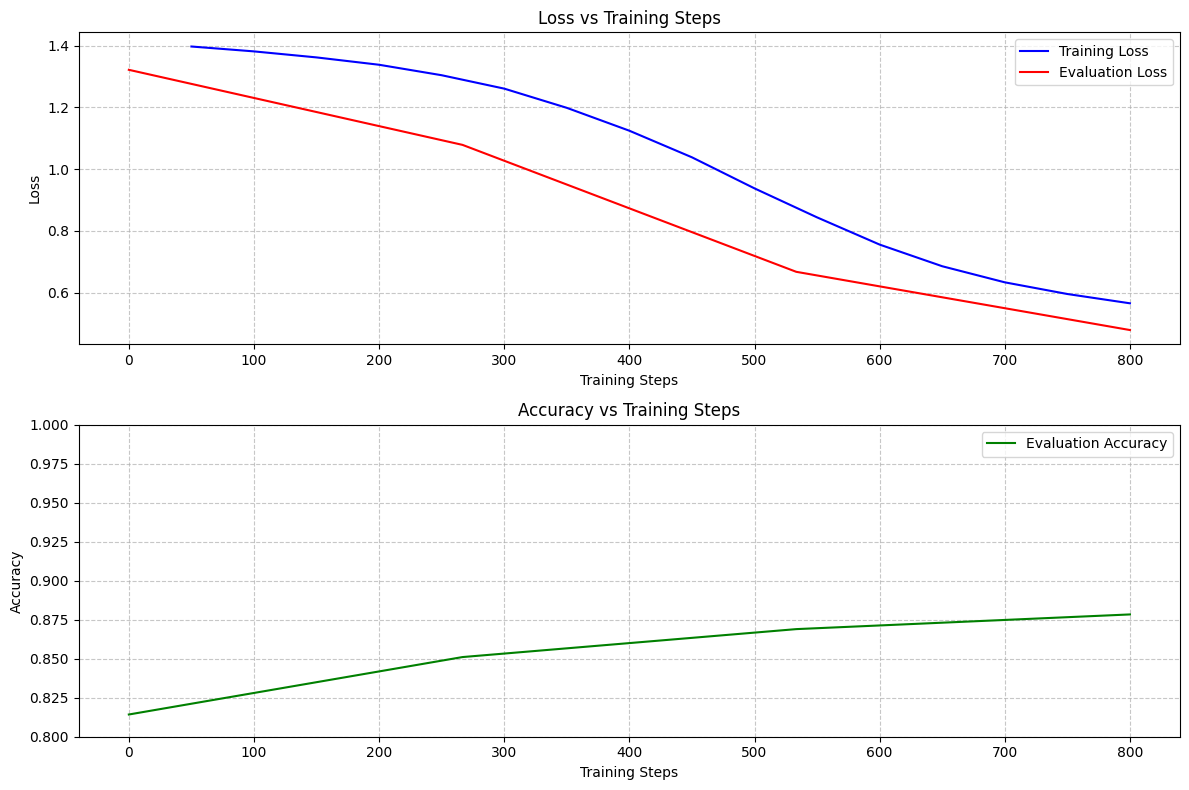

In [26]:
metrics = extract_metrics_from_logs("roberta-lora-agnews-results/checkpoint-800/")
plot_training_metrics(metrics)